In [ ]:
import keras
from keras.models import Model
from keras.layers import *
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [3]:
INPUT_SHAPE = (28, 28, 1)

BATCH_SIZE = 16

# DATA

### Loading the Datasets

In [ ]:
(train, _), (test, _) = keras.datasets.fashion_mnist.load_data()

### Processing the Datasets

In [5]:
def process(ds):
    processed = np.expand_dims(ds, 3)
    return processed.astype('float32') / 255.

train = process(train)
test = process(test)

In [6]:
train.shape, test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Creating the Noisy Images

In [7]:
def add_noise(ds):
    noisy_ds = ds + 0.2 * tf.random.normal(shape=ds.shape)
    return tf.clip_by_value(noisy_ds, 0., 1.)

noisy_train = add_noise(train)
noisy_test = add_noise(test)

### Combining the Datasets

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((noisy_train, train)).cache().shuffle(60000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((noisy_test, test)).cache().shuffle(10000).batch(BATCH_SIZE)

### Testing the Datasets

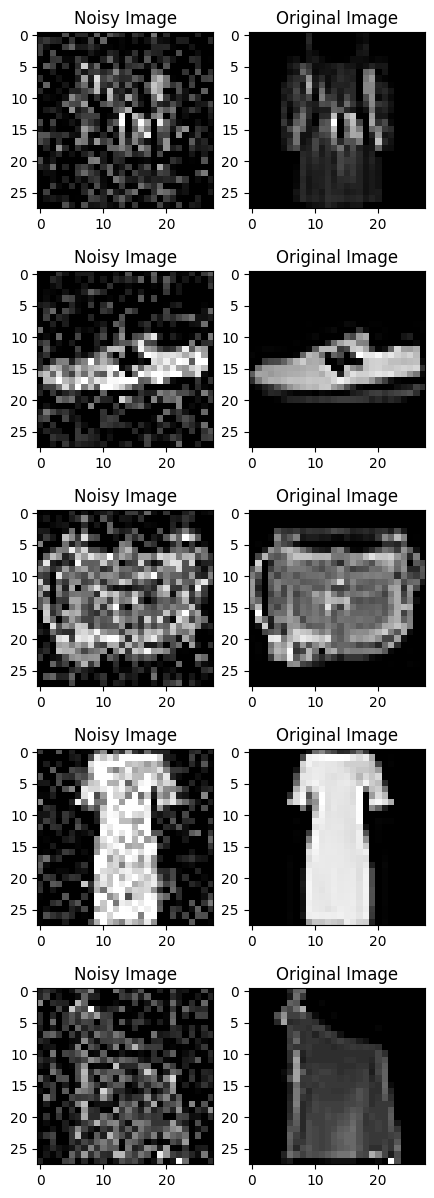

In [20]:
sample = test_ds.as_numpy_iterator().next()

fig, axes = plt.subplots(5, 2, figsize=(5,15))
for i in range(5):
    axes[i][0].imshow(tf.cast(sample[0][i]*255.0, tf.uint8), cmap='gray')
    axes[i][0].set_title('Noisy Image')
    axes[i][1].imshow(tf.cast(sample[1][i]*255.0, tf.uint8), cmap='gray')
    axes[i][1].set_title('Original Image')

# MODEL

### Building the Model

In [21]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.model = self.build_model()


    # Builds the Autoencoder
    def build_model(self):
        input = Input(shape=INPUT_SHAPE)

        # Encoder
        x = Conv2D(32, 3, 1, padding='same', activation='relu')(input)
        x = MaxPooling2D(2, 2, padding='same')(x)
        x = Conv2D(32, 3, 1, padding='same', activation='relu')(x)
        x = MaxPooling2D(2, 2, padding='same')(x)

        # Decoder
        x = Conv2DTranspose(32, 2, 2, padding='same', activation='relu')(x)
        x = Conv2DTranspose(32, 2, 2, padding='same', activation='relu')(x)
        out = Conv2D(1, 3, 1, padding='same', activation='sigmoid')(x)
        return Model(inputs=input, outputs=out)


    def call(self, inputs):
        return self.model(inputs)


    def summary(self):
        self.model.summary()

    # Saves the Autoencoder
    def save(self, file_path):
        self.model.save(file_path)

In [22]:
model = Autoencoder()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 32)        4128

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy')

### Training the Model

In [ ]:
model.fit(train_ds, epochs=10, validation_data=test_ds)

### Testing the Model

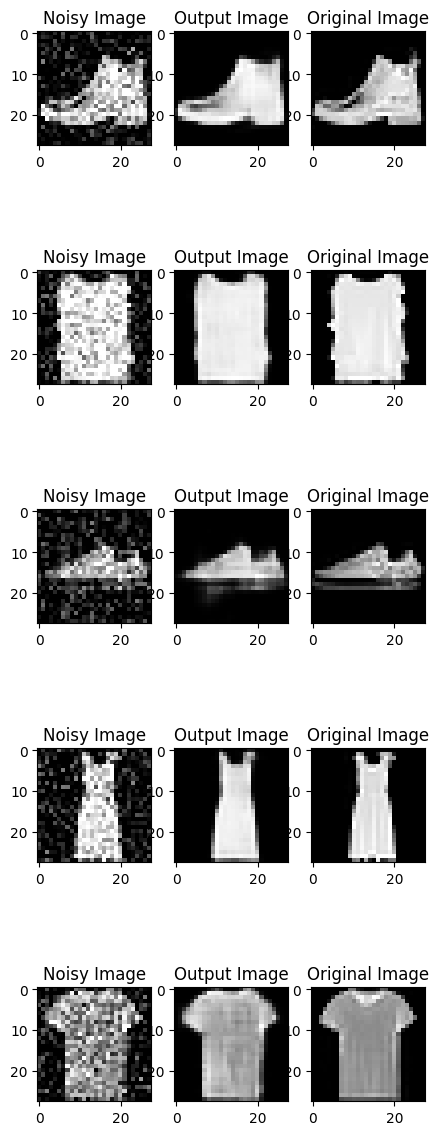

In [26]:
sample = test_ds.as_numpy_iterator().next()
output = model(sample[0])

fig, axes = plt.subplots(5, 3, figsize=(5,15))
for i in range(5):
    axes[i][0].imshow(tf.cast(sample[0][i]*255.0, tf.uint8), cmap='gray')
    axes[i][0].set_title('Noisy Image')
    axes[i][1].imshow(tf.cast(output[i]*255.0, tf.uint8), cmap='gray')
    axes[i][1].set_title('Output Image')
    axes[i][2].imshow(tf.cast(sample[1][i]*255.0, tf.uint8), cmap='gray')
    axes[i][2].set_title('Original Image')

### Saving the Model

In [ ]:
model.save('Autoencoder.h5')